# Dynamics of a Spin Chain using cuQuantum backend

### Introduction

In this tutorial, we will simulate a spin chain (also called the Heisenberg model), which consists of $N$ $\frac{1}{2}$-spins/qubits in a magnetic field. Each spin can interact with its direct neighbors. This model is often used for the study of magnetic systems.

This roughly follows the tutorial **Master Equation Solver: Dynamics of a Spin Chain**, but focuses on different ways to perform the computation on a GPU. For further details on the physics of the simulated problem, please refer to the former notebook.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip_cuquantum
from cuquantum.densitymat import WorkStream
from qutip import (about, basis, expand_operator, mcsolve, mesolve, qeye, # noqa F401
                   sesolve, sigmax, sigmay, sigmaz, tensor)

%matplotlib inline

We first prepare a GPU context to run the simulation on. If only one GPU is available, the default workstream can be used. But for multi-GPU or MPI processes, more options are available. See NVIDIA's documentation for more details.

In [2]:
ctx = WorkStream()

### Creating the system:

**cuQuantum** does not use a sparse matrix representation, as QuTiP does. Instead, it keeps track of each elementary matrix constructing the operators and the mode of the Hilbert space they act on.

With the QuTiP interface, this means we must choose to use the backend before compounding the modes into a larger operator (before any calls to `tensor` or the creation of superoperators). This can be done manually by using identity matrices in the cuQuantum format for tensor operations:

In [3]:
N = 8

eye = qeye(2, dtype="CuOperator")
sz_list = []
for i in range(N):
    op_list = [eye] * N
    op_list[i] = sigmaz(dtype="Dia")
    sz_list.append(tensor(op_list))

sz_list[0].dtype

qutip_cuquantum.operator.CuOperator

While it is not needed to use the ``cuquantum.densitymat`` format directly to use it in QuTiP, we can take a quick look at it to see that our operator contains a single 2x2 matrix acting on a single mode:

In [4]:
oper = sz_list[0].data_as()
print(type(oper))
print(oper.modes)
print(oper.terms)
print(oper.terms[0][0].shape)

<class 'cuquantum.densitymat.operators.OperatorTerm'>
[[(0,)]]
[[<cuquantum.densitymat.elementary_operator.MultidiagonalOperator object at 0x7d73629297f0>]]
(2, 2)


There is also a context that, when activated, automatically creates operators in the cuQuantum format:

In [5]:
def create_spin_chain_Hamiltonian(N: int, h: float, J: float):
    sx_list = [expand_operator(sigmax(), [2] * N, i) for i in range(N)]
    sy_list = [expand_operator(sigmay(), [2] * N, i) for i in range(N)]
    sz_list = [expand_operator(sigmaz(), [2] * N, i) for i in range(N)]

    H = -0.5 * h * sum(sz_list)
    for n in range(N - 1):
        H += -0.5 * J * sx_list[n] * sx_list[n + 1]
        H += -0.5 * J * sy_list[n] * sy_list[n + 1]
        H += -0.5 * J * sz_list[n] * sz_list[n + 1]

    return H


h = 0.2 * np.pi
J = 0.2 * np.pi

with qutip_cuquantum.CuQuantumBackend(ctx):
    H = create_spin_chain_Hamiltonian(N, h, J)

H.dtype

qutip_cuquantum.operator.CuOperator

This context changes how QuTiP creates `Qobj` from functions (`qeye`, `sigmax`, `destroy`, `basis`, etc.) and alters solver options. Inside this context, manually setting the `dtype` as ``CuOperator`` is not needed, but using other formats can still be useful. For example, CSR matrices are converted to dense arrays (``cuquantum.densitymat`` supports diagonal and dense elementary operators), so manually choosing diagonal matrix it still usefull.

These operators can be used normally for most QuTiP operations, but this often means that they are converted to a dense array and then used as normal operators. They can be used in QuTiP's main solvers to accelerate simulation by leveraging the GPU. This is done by calling the solver and using the result inside the context window:

Text(0.5, 1.0, 'Dynamics of spin chain')

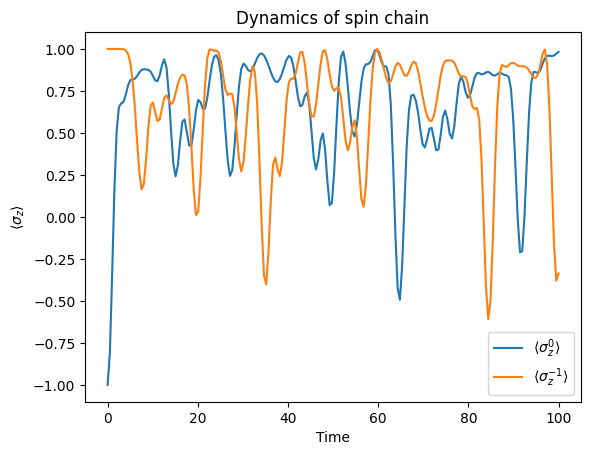

In [6]:
with qutip_cuquantum.CuQuantumBackend(ctx):
    psi0 = basis([2] * N, [1] + [0] * (N - 1))
    times = np.linspace(0, 100, 200)
    result = sesolve(H, psi0, times, e_ops=sz_list)

    exp_sz = np.array([exp.get() for exp in result.expect])[..., 0]

plt.plot(times, exp_sz[0, :], label=r"$\langle \sigma_z^{0} \rangle$")
plt.plot(times, exp_sz[-1, :], label=r"$\langle \sigma_z^{-1} \rangle$")
plt.legend(loc="lower right")
plt.xlabel("Time"), plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Dynamics of spin chain")

As shown, the resulting expectation values are not numpy arrays, but CuPy arrays. The method ``get`` is required to transfer them from the GPU to the CPU. 

Outside the context, the expectation values can be obtained from the result with `e_data` as a list of single GPU values:

In [7]:
print(type(result.e_data[0][0]))
exp_sz = np.array([[value.get() for value in result.e_data[i]] for i in result.e_data])[
    ..., 0
]  # remove the extra dimension from each value being a 1 element 1D array.

<class 'cupy.ndarray'>


### Dephasing and trajectory solver

Let's add the dissipation process and use the Monte-Carlo solver to simulate it.

In [8]:
gamma = 0.02

# sz_list operators are already in the cuQuantum format,
# so further modification can be done outside the context
c_ops = [np.sqrt(gamma) * sz_list[i] for i in range(N)]

# However the solver must be called inside the context
with qutip_cuquantum.CuQuantumBackend(ctx):
    psi0 = basis([2] * N, [1] + [0] * (N - 1))
    times = np.linspace(0, 100, 200)
    result = mcsolve(
        H, psi0, times, c_ops, e_ops=sz_list, options={"map": "serial"}, ntraj=10
    )

    exp_sz_mc = np.array([exp.get() for exp in result.average_expect])

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:  19.91s. Est. time left: 00:00:01:19
30.0%. Run time:  39.19s. Est. time left: 00:00:01:31
40.0%. Run time:  59.57s. Est. time left: 00:00:01:29
50.0%. Run time:  79.33s. Est. time left: 00:00:01:19
60.0%. Run time:  98.91s. Est. time left: 00:00:01:05
70.0%. Run time: 119.47s. Est. time left: 00:00:00:51
80.0%. Run time: 139.08s. Est. time left: 00:00:00:34
90.0%. Run time: 158.88s. Est. time left: 00:00:00:17
100.0%. Run time: 180.28s. Est. time left: 00:00:00:00
Total run time: 202.45s


Text(0.5, 1.0, 'Dynamics of spin chain')

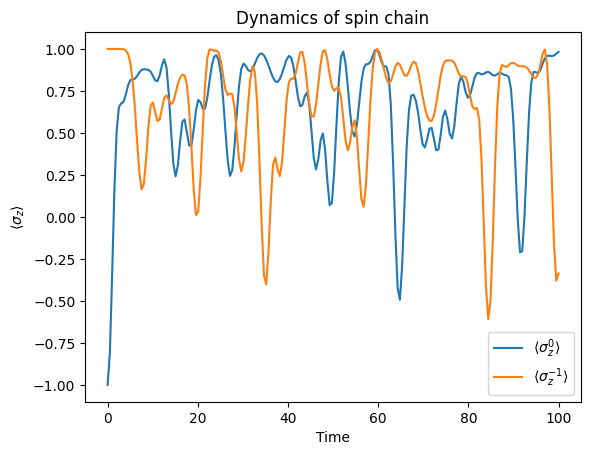

In [9]:
plt.plot(times, exp_sz[0, :], label=r"$\langle \sigma_z^{0} \rangle$")
plt.plot(times, exp_sz[-1, :], label=r"$\langle \sigma_z^{-1} \rangle$")
plt.legend(loc="lower right")
plt.xlabel("Time"), plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Dynamics of spin chain")

## Tricks and best practice

QuTiP and ``cuQuantum.densitymat`` have quite different approaches and do not always play well together. This results in multiple limitations and requires care to be taken.

``cuQuantum.densitymat`` is there to optimize the ``Operator @ State`` operation for large compound systems. QuTiP uses this operation to optimize solvers, but little effort has been made to support other features with this backend. So using it blindly will often not give any benefits.

It is best to create the elementary operators first in pure QuTiP mode if any of the following apply:
* Rectangular operators are used for intermediate states. For example, creating an operator using `ket @ bra`. They are not supported in cuQuantum operators.
* **Dense** transformations (`expm`, `sqrtm`, `sinm`, etc.) are used. When applied to a cuQuantum operator, the internal structure will be lost.

In [10]:
# Do
H1 = (0.2 * sigmax() + 0.5 * sigmay()).expm() & qeye([2, 2], dtype="CuOperator")

# Don't
with qutip_cuquantum.CuQuantumBackend(ctx):
    sx = sigmax() & qeye(2) & qeye(2)
    sy = sigmay() & qeye(2) & qeye(2)
    H2 = (0.2 * sx + 0.5 * sy).expm(dtype="CuOperator")

print("operator shape pre computed", H1.data_as().terms[0][0].shape)
print("operator shape post computed", H2.data_as().terms[0][0].shape)

converting to Dense
operator shape pre computed (2, 2)
operator shape post computed (8, 8)


## Solver Methods and Optimization

Specialized integrator methods are needed for the GPU backend: ``CuTsit5``, ``CuVern7`` (new default set in the context), and ``CuVern9``. In most cases, the default is good enough, but ``CuTsit5`` uses fewer derivatives, and therefore less GPU memory. Using it can be needed for larger simulations. It is also often the fastest with normal tolerance. ``CuVern9`` can be good with very small error tolerance, but uses a lot more memory. ``CuVern7`` is the in-between: never the best, never the worst.

Setting ``options={"interpolate": False}`` can save close to 40% memory for the Verner methods and is recommended for large simulations.

In [11]:
with qutip_cuquantum.CuQuantumBackend(ctx):
    psi0 = basis([2] * N, [1] + [0] * (N - 1))
    times = np.linspace(0, 100, 200)
    %time result = mesolve(H, psi0, times, c_ops, e_ops=sz_list, options={"method": "CuTsit5"})
    %time result = mesolve(H, psi0, times, c_ops, e_ops=sz_list, options={"method": "CuVern7"})
    %time result = mesolve(H, psi0, times, c_ops, e_ops=sz_list, options={"method": "CuVern9"})

CPU times: user 15 s, sys: 47.9 s, total: 1min 2s
Wall time: 1min 2s
CPU times: user 25.2 s, sys: 1min 25s, total: 1min 50s
Wall time: 1min 49s
CPU times: user 33.6 s, sys: 1min 52s, total: 2min 25s
Wall time: 2min 24s


#### About performance
This backend can allow to use powerful hardware and to scale simulation to multiple GPU. It is however not great with small simulations. It has a large overhead and will only perform well for large simulations that use a significant fraction of the GPU memory. Also, a CUDA-aware MPI is needed to be efficient on multiple nodes.

In [12]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+f15c8f2
Numpy Version:      2.3.4
Scipy Version:      1.16.2
Cython Version:     3.1.6
Matplotlib Version: 3.10.7
Python Version:     3.13.9
Number of CPUs:     12
BLAS Info:          scipy-openblas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  

Installed QuTiP family packages
-------------------------------

qutip-cuquantum: 0.2.0.dev5+dd5394a

Please cite QuTiP in your publication.
For your